In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import email
import os

from bs4 import BeautifulSoup
from sklearn.base import BaseEstimator, TransformerMixin
from wordcloud import WordCloud
import regex as re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ST\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Extraction from raw E-Mail Files.

In [2]:
root_dir = os.getcwd()

ham_folder = os.path.join(root_dir,'main_ham')
spam_folder = os.path.join(root_dir,'main_spam')
ham_files = os.listdir(ham_folder)
spam_files = os.listdir(spam_folder)

In [3]:
len(ham_files)

6951

In [4]:
len(spam_files)

2398

In [5]:
def clean_html(email):
    '''
    To clean any html content in emails.
    :param email: string of html tags and content
    :return: a clean string with no html tags or styling
    '''

    try:
        soup = BeautifulSoup(email.get_payload(), "html.parser")
        plain = soup.text.replace("=\n", "")
        plain = re.sub(r"\s+", " ", plain)
        return plain.strip()
    except:
        return "nothing"

In [6]:
def parse_email(path):
    with open(path, 'rb') as f:
        return email.parser.BytesParser().parse(f)

def email_to_text(mail):
    '''
    This function takes a parsed email and returns the content of the mail
    :param mail: parsed mail object
    :return: body content after cleaning any html tags present
    '''

    text_content = ""
    for part in mail.walk():
        part_content_type = part.get_content_type()
        if part_content_type not in ['text/plain', 'text/html']:
            continue
        if part_content_type == 'text/plain':
            text_content += part.get_payload()
        else:
            text_content += clean_html(part)

    return text_content

class EmailToText(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass
    def fit(self, mail):
        return self
    def transform(self, mail):
        return email_to_text(parse_email(mail))

In [7]:
test_ham = []
for file in ham_files:
    file_path = os.path.join(ham_folder, file)
    test_ham.append(parse_email(file_path))

test_spam = []
for file in spam_files:
    file_path = os.path.join(spam_folder, file)
    test_spam.append(parse_email(file_path))

In [8]:
print(len(test_ham), len(test_spam))    # All set, parse_email() is able to parse all files.

6951 2398


In [9]:
extractor = EmailToText()

In [10]:
df = {}
for file in spam_files:
    df[extractor.transform(os.path.join(spam_folder, file))] = 'spam'
for file in ham_files:
    df[extractor.transform(os.path.join(ham_folder, file))] = 'ham'

In [11]:
data = pd.DataFrame.from_dict(df, orient='index', columns=['label']).reset_index(names='mail')
data.to_csv('datasets/data_v1.csv', index=False)
del df

In [12]:
data[data['mail'] == 'nothing']

,mail,label


In [13]:
data.shape

(6003, 2)

In [14]:
data.head()

,mail,label
0,mv 1 00001.bfc8d64d12b325ff385cca8d07b84288\nm...,spam
1,Greetings!\n\nYou are receiving this letter be...,spam
2,</TR> Save up to 70% on Life Insurance. Why Sp...,spam
3,"The Need For Safety Is Real In 2002, You Might...",spam
4,1) Fight The Risk of Cancer!\nhttp://www.adcli...,spam


## Cleaning the Dataset and the body text.

In [15]:
data = data.drop(data[data['mail'] == 'nothing'].index, axis=0).reset_index(drop=True)

In [16]:
data.head()

,mail,label
0,mv 1 00001.bfc8d64d12b325ff385cca8d07b84288\nm...,spam
1,Greetings!\n\nYou are receiving this letter be...,spam
2,</TR> Save up to 70% on Life Insurance. Why Sp...,spam
3,"The Need For Safety Is Real In 2002, You Might...",spam
4,1) Fight The Risk of Cancer!\nhttp://www.adcli...,spam


In [17]:
data.iloc[0,0]

'mv 1 00001.bfc8d64d12b325ff385cca8d07b84288\nmv 10 00010.7f5fb525755c45eb78efc18d7c9ea5aa\nmv 100 00100.c60d1c697136b07c947fa180ba3e0441\nmv 101 00101.2dfd7ee79ae439b8d9c38e783a137efa\nmv 102 00102.2e3969075728dde7a328e05d19b35976\nmv 103 00103.8c39bfed2079f865e9dfb75f4416a468\nmv 104 00104.886f4a22362f4d3528c3e675878f17f7\nmv 105 00105.9790e1c57fcbf7885b7cd1719fb4681b\nmv 106 00106.fa6df8609cebb6f0f37aec3f70aa5b9a\nmv 107 00107.f1d4194b57840ea6587b9a73ed88e075\nmv 108 00108.4506c2ef846b80b9a7beb90315b22701\nmv 109 00109.601a9cd8272f22236b27e95dbe2fa22d\nmv 11 00011.2a1247254a535bac29c476b86c708901\nmv 110 00110.20934dc65c9a88fc9c6afda9952ce2c5\nmv 111 00111.a163d41592b3a52747d7521341a961af\nmv 112 00112.ec411d26d1f4decc16af7ef73e69a227\nmv 113 00113.ff113297f0ed07536d288c7b2193a8ec\nmv 114 00114.c104ada3a249e1e1846c0cd156a303e9\nmv 115 00115.d7c257361675ee5d45baa552205fb472\nmv 116 00116.8e13644b995f98dbab198b71e26f67ec\nmv 117 00117.33011fddf61efe5f453a14468ff7e629\nmv 118 00118.4be

In [18]:
data[data['mail'].str.match(r"mv (\d+) (\d{5})\.([a-f0-9]{32})", na=False)]

,mail,label
0,mv 1 00001.bfc8d64d12b325ff385cca8d07b84288\nm...,spam


In [19]:
data = data.drop(index = [0]).reset_index(drop=True)

In [20]:
data.head()

,mail,label
0,Greetings!\n\nYou are receiving this letter be...,spam
1,</TR> Save up to 70% on Life Insurance. Why Sp...,spam
2,"The Need For Safety Is Real In 2002, You Might...",spam
3,1) Fight The Risk of Cancer!\nhttp://www.adcli...,spam
4,1) Fight The Risk of Cancer!\nhttp://www.adcli...,spam


In [21]:
data.duplicated().sum()

np.int64(0)

In [22]:
class CleanBody(BaseEstimator, TransformerMixin):
    '''
    transform a normal english email into preprocessed text optimal for spam classification
    '''

    def __init__(self):
        self.ps = PorterStemmer()
        self.stopwords = set(stopwords.words('english'))

    def fit(self, column):
        return self

    def transform(self, column):
        self.mails = column.values
        self.feature_names_ = ['mail']
        cleaned_mails = []
        for mail in self.mails:
            mail = re.sub(r'\n', '', mail)  # remove the raw newline character
            mail = mail.lower()  # turn everything into lowercase
            mail = re.sub(r'http\S+|www\.\S+', '', mail)  # remove all links
            mail = re.sub(r'\b[\w.-]+?@[\w.-]+\.\w+\b', '', mail)  # remove all e-mail addresses

            words = mail.split()
            filtered = [self.ps.stem(word) for word in words if word not in self.stopwords]   # remove all the stopwords
            mail = ' '.join(filtered)

            mail = re.sub(r'([!?])', r' \1 ', mail)  #
            mail = re.sub(r'\s+', ' ', mail)  # Normalize spaces

            mail = re.sub(r'[^\p{Sc}A-Za-z0-9 !?]+', '', mail)    # remove all special characters except spaces and currency symbols
            mail = mail.strip()    # remove trailing and leading whitespaces
            cleaned_mails.append(mail)

        return pd.DataFrame(np.array(cleaned_mails).reshape(-1, 1), columns=self.feature_names_)

    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names_)

In [23]:
cleaner = CleanBody()

data['mail'] = cleaner.transform(data['mail'])

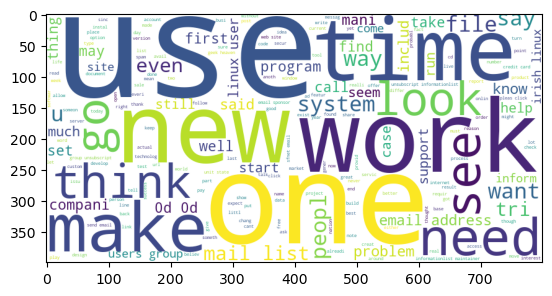

In [99]:
wc = WordCloud(width=800, height=400, background_color='white')
wc.generate(" ".join(data['mail']))
plt.imshow(wc)

# Our class works! We can easily implement a pipeline now.

In [100]:
data[data['mail'] == '']

,mail,label
251,,spam
1596,,spam
3630,,ham


In [101]:
data = data.drop(index = data[data['mail'] == ''].index).reset_index(drop=True)

In [102]:
data.to_csv('datasets/data_v2.csv', index=False)